In [1]:
import numpy as np
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX  

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:

fred = Fred(api_key='321467cef92af0c44aa2aaf01257acc5')
cpi = fred.get_series('CPIAUCSL')
inflation = cpi.pct_change(periods = 12) * 100 
inflation.dropna(inplace = True)
inflation_df = pd.DataFrame(inflation, columns=['inflation'])
inflation_df = inflation_df.resample('ME').last()
inflation_df.index.name = 'date'
inflation_df = inflation_df[inflation_df.index >= '1986-02-28 00:00:00']
inflation_df.head(10)                                                                                                                                                                                                                                                   

/var/folders/3s/r8gqdd0d04xdvr0f7g1hb2r00000gn/T/ipykernel_89119/4086233878.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  inflation = cpi.pct_change(periods = 12) * 100


,inflation
date,
1986-02-28,3.198495
1986-03-31,2.153558
1986-04-30,1.588785
1986-05-31,1.679104
1986-06-30,1.767442
1986-07-31,1.671309
1986-08-31,1.575533
1986-09-30,1.757632
1986-10-31,1.566820


In [3]:
oil = fred.get_series('DCOILWTICO') 
unemployment = fred.get_series('UNRATE')    
m2 = fred.get_series('M2SL')

exo_df = pd.DataFrame({'oil': oil, 'unemployment': unemployment, 'm2': m2})
exo_df = exo_df.resample('ME').last()  
exo_df.index.name = 'date'

inflation_exo = pd.concat([inflation_df, exo_df], axis=1)
inflation_exo.ffill(inplace=True)
inflation_exo.dropna(inplace=True)

inflation_exo['oil_diff'] = inflation_exo['oil'].diff() 
inflation_exo['m2_diff'] = inflation_exo['m2'].diff()
inflation_exo.dropna(inplace=True) 

inflation_exo.head(10)

,inflation,oil,unemployment,m2,oil_diff,m2_diff
date,,,,,,
1986-03-31,2.153558,10.25,7.2,2533.1,-2.98,20.2
1986-04-30,1.588785,13.38,7.1,2557.8,3.13,24.7
1986-05-31,1.679104,14.30,7.2,2584.8,0.92,27.0
1986-06-30,1.767442,12.80,7.2,2605.0,-1.50,20.2
1986-07-31,1.671309,11.23,7.0,2626.6,-1.57,21.6
1986-08-31,1.575533,15.93,6.9,2646.5,4.70,19.9
1986-09-30,1.757632,14.70,7.0,2667.8,-1.23,21.3
1986-10-31,1.566820,15.25,7.0,2687.4,0.55,19.6
1986-11-30,1.284404,15.00,6.9,2701.3,-0.25,13.9


In [4]:
train_size_no_exo = int(len(inflation_df) * 0.8)
train = inflation_df['inflation'][:train_size_no_exo]
test = inflation_df['inflation'][train_size_no_exo:] 

model_no_exo = SARIMAX(train, order = (1,1,1), seasonal_order = (2,1,1,12))
fit_no_exo = model_no_exo.fit(disp = False)


def forecast_no_exo(fit_no_exo, forecast_steps):
    forecast = fit_no_exo.forecast(steps=forecast_steps)   
    return forecast

forecast_steps = len(test)

forecast_no_exo = forecast_no_exo(fit_no_exo, forecast_steps)

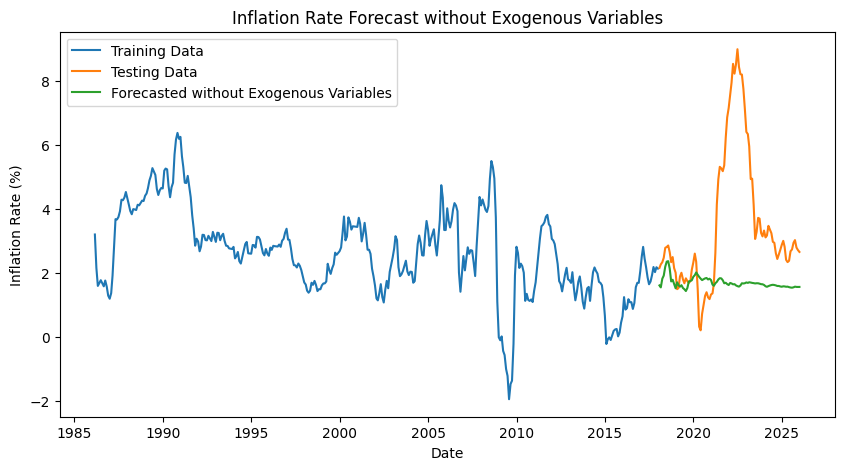

In [5]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label = 'Training Data')
plt.plot(test.index, test, label = 'Testing Data')
plt.plot(forecast_no_exo.index, forecast_no_exo, label = 'Forecasted without Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.title('Inflation Rate Forecast without Exogenous Variables')
plt.legend()
plt.show()

In [6]:
train_size_exo = int(len(inflation_exo)*0.8)
train_exo = inflation_exo.iloc[:train_size_exo]
test_exo = inflation_exo.iloc[train_size_exo:]

model_exo = SARIMAX(train_exo['inflation'], exog = train_exo[['oil_diff', 'unemployment', 'm2_diff']], order=(1,1,1), seasonal_order=(2,1,1,12), )
fit_exo = model_exo.fit(disp=False)

exog=test_exo[['oil_diff', 'unemployment', 'm2_diff']].iloc[:forecast_steps]

forecast_steps_exo = len(test_exo)

def forecast_exo(fit_exo, forecast_steps_exo, exog):
    forecast = fit_exo.forecast(steps=forecast_steps_exo, exog=exog)   
    return forecast

forecast_exo = forecast_exo(fit_exo, forecast_steps_exo, exog)

/Users/nitinvinayak/Personal/inflationmodeling/venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


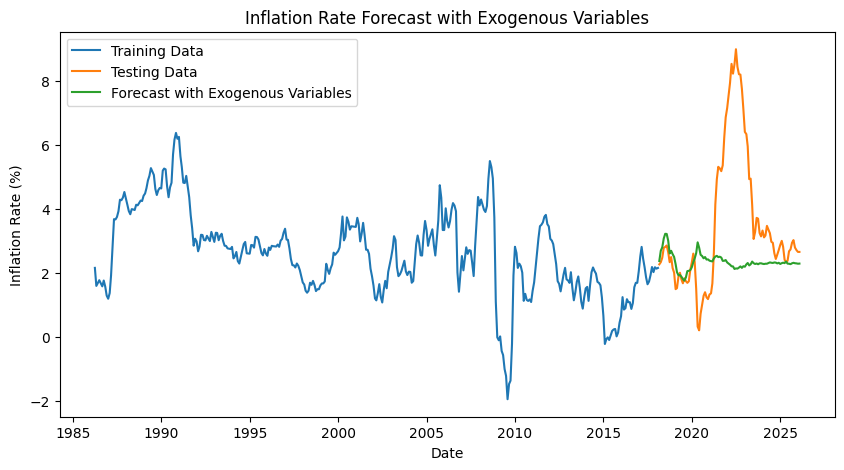

In [7]:
plt.figure(figsize=(10,5))
plt.plot(train_exo.index, train_exo['inflation'], label = 'Training Data')
plt.plot(test_exo.index, test_exo['inflation'], label = 'Testing Data')
plt.plot(forecast_exo.index, forecast_exo, label = 'Forecast with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.title('Inflation Rate Forecast with Exogenous Variables')
plt.legend()
plt.show()

In [8]:
rmse_no_exo = np.sqrt(mean_squared_error(test.iloc[:forecast_steps], forecast_no_exo))
mae_no_exo = mean_absolute_error(test.iloc[:forecast_steps], forecast_no_exo)
print('Root Mean Squared Error: ', round(rmse_no_exo, 4))
print('Mean Absolute Error: ', round(mae_no_exo, 4))

Root Mean Squared Error:  2.8447
Mean Absolute Error:  1.9908


In [11]:
rmse_exo = np.sqrt(mean_squared_error(test_exo['inflation'].iloc[:forecast_steps_exo], forecast_exo))
mae_exo = mean_absolute_error(test_exo['inflation'].iloc[:forecast_steps_exo], forecast_exo)
print('Root Mean Squared Error: ', round(rmse_exo, 4))
print('Mean Absolute Error: ', round(mae_exo, 4))

Root Mean Squared Error:  2.513
Mean Absolute Error:  1.6422


In [12]:
rmse_pct_change = ((rmse_no_exo - rmse_exo) / rmse_no_exo) * 100
mae_pct_change = ((mae_no_exo - mae_exo) / mae_no_exo) * 100

print(f'RMSE Percentage Change:  {round(rmse_pct_change, 2)}%')
print(f'MAE Percentage Change:  {round(mae_pct_change, 2)}%')

RMSE Percentage Change:  11.66%
MAE Percentage Change:  17.51%
